In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## BALANCEO DE CLASES

In [9]:
path = './datasets/mitbih_train.csv'
df = pd.read_csv(path, header=None)
df.rename(columns={187:"label"}, inplace=True) #renombrar la columna de label

Distribución de clases:
 label
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

Porcentaje por clase:
 label
0.0    82.77
4.0     7.35
2.0     6.61
1.0     2.54
3.0     0.73
Name: proportion, dtype: float64


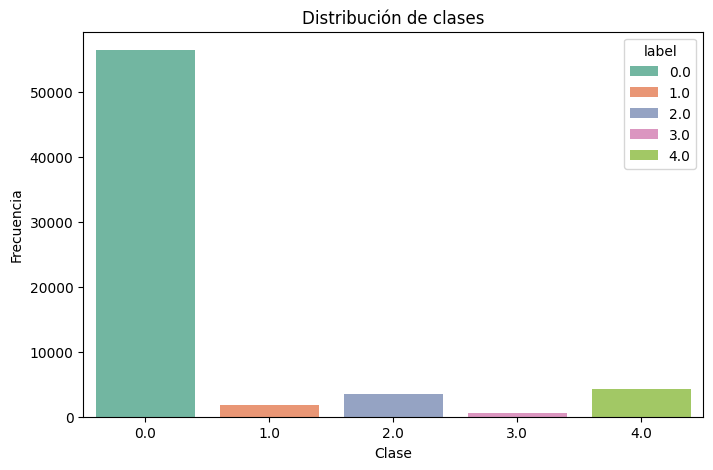

In [10]:
# Conteo de clases
class_counts = df['label'].value_counts()
print("Distribución de clases:\n", class_counts)

# Porcentaje de cada clase
class_percentages = df['label'].value_counts(normalize=True) * 100
print("\nPorcentaje por clase:\n", class_percentages.round(2))

# Visualización
plt.figure(figsize=(8, 5))
sns.countplot(x='label', hue='label', data=df, palette='Set2', )
plt.title('Distribución de clases')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()


Al revisar nuestro dataset de training, observamos que la proporción de labels de la clase 0 es considerablemente mayor, (el 82.7%) del total de los datos, que las otras clases. Inclusive hay una clase que representa menos del 1% (clase 3). Las otras 3 clases, contienen entre el 2% y 7% de los datos. Por lo anterior, se infiere que el dataset está desbalanceado.

## Pipeline con balanceo de clases

A continuación se ilustra, la implementación del balanceo de clases y busqueda de hiperparametros utilizando Pipelines.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Basic python libraries
import os
import time
import joblib
import pandas as pd
import numpy as np

# Visualizarition libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn and other ml functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report, recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
)

# libraries for decision trees
from sklearn.tree import DecisionTreeClassifier



La librería Sklearn no permite el balanceo de clases integrado en el Pipeline, por lo que se realizará por separado. El balance de clases siempre se debe realizar despues de dividir los datos en train y test, para evitar filtrar información del test set hacia el train set, lo que introduce data leakage.

In [12]:
import os
import joblib
import numpy as np
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score,
    f1_score, confusion_matrix, roc_auc_score, classification_report
)

def evaluate_and_save_model(grid_search_fitted, model_name, X_test, y_test, training_time):
    """
    Evalúa el mejor modelo de un GridSearchCV y guarda sus resultados.

    Parámetros:
    - grid_search_fitted (GridSearchCV): GridSearchCV ya entrenado.
    - model_name (str): Nombre del modelo (prefijo para archivos).
    - X_test, y_test: Datos de prueba.
    - training_time (float): Tiempo de entrenamiento.

    Salida:
    - None. Guarda dos archivos .pkl en carpetas /models y /results.
    """

    # Crear directorios si no existen
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)

    # Mejor estimador
    best_estimator = grid_search_fitted.best_estimator_
    y_pred = best_estimator.predict(X_test)

    # Probabilidades y AUC
    if hasattr(best_estimator, "predict_proba"):
        y_pred_proba = best_estimator.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    elif hasattr(best_estimator, "decision_function"):
        y_pred_proba = best_estimator.decision_function(X_test)
        auc = np.nan
    else:
        y_pred_proba = None
        auc = np.nan

    # Métricas
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Resultados a guardar
    results = {
        'precision_test': precision,
        'recall_test': recall,
        'accuracy_test': accuracy,
        'f1_score_test': f1,
        'confusion_matrix': cm,
        'y_pred_prob': y_pred_proba,
        'auc_test': auc,
        'classification_report': report,
        'cpu_time': training_time,
        'best_params': grid_search_fitted.best_params_,
        'best_recall_cv': grid_search_fitted.best_score_,
        'cv_results': grid_search_fitted.cv_results_
    }

    # Guardar resultados y modelo
    joblib.dump(results, f"results/{model_name}_results.pkl")
    joblib.dump(best_estimator, f"models/best_{model_name}_model.pkl")
    print(f"✅ Modelo y resultados guardados en:\n- models/best_{model_name}_model.pkl\n- results/{model_name}_results.pkl")


In [13]:
# Separar características (X) y etiqueta (y)
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [14]:
# Instanciar SMOTE
sm = SMOTE(random_state=42)

# Ajustar y transformar (resamplear) los datos
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

A continuación, se creará el Pipeline para:
- Realizar GridSearch con Cross validation para un arbol de clasificación

El escalado de variables se dejara comentado debido a que ya las columnas del dataset se encuentran con valores entre 0 y 1.

In [15]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_bal, y_train_bal)

DecisionTreeClassifier(random_state=42)

In [ ]:
#2. Modelo SVC
#svc_model = SVC(random_state=42, probability=True)
tree_model = DecisionTreeClassifier(random_state=42)


#3. Instanciar el Pipe
pipe = Pipeline([
  # ("scaler",StandardScaler()), #Escalador
  #("model", svc_model) #Modelo #
  ("model", tree_model) #Modelo
])

#Fit del Pipe con clases balanceadas - Si no quiero hacer GridSearch puedo finalizar aquí
#pipe.fit(X_train_bal, y_train_bal)

#4. ---- GridSearch ----
#a.  Definimos parametros del GS
""" param_grid = {
    'model__C': [0.1, 1.0, 10.],
    'model__kernel': ['linear', 'rbf'],
    #'gamma': ['scale', 'auto']
} """

tree_param_grid = {
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__criterion': ['gini', 'entropy'],
}

#b. Creamos el GridSearch
scorer = "recall_macro"
grid = GridSearchCV(pipe, param_grid= tree_param_grid , cv=5, scoring= scorer)

#5. Se hace Fit al Grid

# Entrenamiento y ajuste del modelo
start_time_svc = time.time()
grid.fit(X_train_bal, y_train_bal)
training_time_svc = time.time() - start_time_svc

# Nombre del modelo
svc_model_name = "svc"

# Evaluación y guardado del modelo
evaluate_and_save_model(grid, svc_model_name, X_test, y_test, training_time_svc)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

In [ ]:
svc_results = joblib.load("results/svc_results.pkl")
cv_results_df = pd.DataFrame(svc_results['cv_results'])

In [ ]:
pivot = cv_results_df.pivot_table(index='param_C',
                                  columns='param_kernel',
                                  values='mean_test_score')
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Recall (macro)")
plt.xlabel("kernel")
plt.ylabel("C")
plt.show()